In [1]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

In [2]:
sim = WavefunctionSimulator(random_seed=1337)

In [3]:
def solve_vqe(hamiltonian: PauliSum, numQubit, numLayer) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    theta_init = np.random.rand(2*numQubit*numLayer) * 2 * np.pi

    def ansatz_energy(theta_vec):
        p = None
        p = Program()
        for j in range(numLayer):
            for i in range(numQubit):
                p += RX(theta_vec[2*numQubit * j + 2 * i], i)
                p += RZ(theta_vec[2*numQubit * j + 2 * i + 1], i)
            for i in range(numQubit - 1):
                p += CNOT(i, i + 1)

        energy = sim.expectation(p, hamiltonian).real
        return energy

    theta_answer = minimize(ansatz_energy, theta_init, method='L-BFGS-B').x
    return ansatz_energy(theta_answer)

In [4]:
def get_ground_energy(interaction_hamil, numQubit, numLayer):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator(random_seed=1337)
    return solve_vqe(pauliop_hamil, numQubit, numLayer)


In [5]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(h2_interaction_hamil, 4, 5)
    vqe_ground_energies.append(ge)
    print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge)


bond length:  0.3  ground state energy:  -0.6018037097168295
bond length:  0.4  ground state energy:  -0.9141497072217346
bond length:  0.5  ground state energy:  -1.0551592106696503
bond length:  0.6  ground state energy:  -1.1162860071821157
bond length:  0.7  ground state energy:  -1.1361894521867446
bond length:  0.8  ground state energy:  -1.1341476607876486
bond length:  0.9  ground state energy:  -1.120560276803429
bond length:  1.0  ground state energy:  -1.1011503286532849
bond length:  1.1  ground state energy:  -1.0791929366898225
bond length:  1.2  ground state energy:  -1.0567407443742167
bond length:  1.3  ground state energy:  -1.0351862637917943
bond length:  1.4  ground state energy:  -1.0154681865642161
bond length:  1.5  ground state energy:  -0.99814935064735
bond length:  1.6  ground state energy:  -0.9834727242443272
bond length:  1.7  ground state energy:  -0.9714266820966861
bond length:  1.8  ground state energy:  -0.9618169482851484
bond length:  1.9  ground s

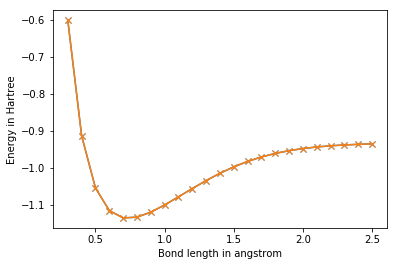

In [7]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()

    # Print out some results of calculation.
#    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
#        bond_length))
#    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
#    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
#    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
#        molecule.nuclear_repulsion))
#    for orbital in range(molecule.n_orbitals):
#        print('Spatial orbital {} has energy of {} Hartree.'.format(
#            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
#plt.plot(bond_lengths, hf_energies, 'o-')
plt.plot(bond_lengths, vqe_ground_energies, 'x-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()